**NOTE**: This notebook implements the class defined in `models/reranker_sentiment.py`, and is intended for testing and exploration of the post-hoc sentiment-aware extension to KeyBERT.

# KeyBERT with Post-hoc Sentiment-aware Re-ranking

This extension enhances the original KeyBERT framework by adjusting the ranking of candidate keywords based not only on semantic similarity, but also on their emotional alignment with the input document.

*The goal is to favour keywords that are both semantically relevant and sentimentally aligned with the overall tone of the review.*

### Theoretical Framework

The original KeyBERT keyword generation is preserved. The modification occurs **after candidate selection**, during the **re-ranking phase**.

Given:
- `cos_sim`: the cosine similarity between a candidate keyword and the document,
- `s_doc ∈ [0, 1]`: the normalized sentiment polarity of the document,
- `s_kw ∈ [0, 1]`: the normalized sentiment polarity of the candidate keyword,

we compute a sentiment alignment score as:

$$
\text{align}(s_{doc}, s_{kw}) = 1 - |s_{doc} - s_{kw}|
$$

To improve comparability with cosine similarity (which ranges in \[-1, 1\]), the alignment is mapped to the same scale:

$$
\text{align\_mapped} = 2 \cdot \text{align} - 1
$$

The final score for each keyword is then:

$$
\text{score}_{\text{final}} = (1 - \alpha)\cdot \text{cos\_sim} + \alpha \cdot \text{align\_mapped}
$$

Where **α ∈ [0, 1]** controls the balance between semantic and sentiment alignment.

### Characteristics

- **Non-intrusive**: reuses the standard KeyBERT keyword generation pipeline.
- **Model-agnostic**: supports any HuggingFace-compatible sentiment classifier (e.g., RoBERTa, BERT, etc.).
- **Tunable**: α allows customization of the importance given to sentiment alignment.
- **Lightweight**: only modifies the ranking step; candidate generation remains unchanged.

This approach serves as a baseline sentiment-aware extension for comparing against more involved strategies (e.g., sentiment-guided candidate filtering).


### Setup: Installing and Importing Required Libraries

In [61]:
import subprocess
import sys

# List of required packages
required_packages = [
    "keybert", "sentence-transformers", "transformers", "torch", "scikit-learn", "pandas",
    "matplotlib", "seaborn", "tqdm", "wordcloud"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

keybert is already installed.
Installing sentence-transformers...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


transformers is already installed.
torch is already installed.
Installing scikit-learn...
Defaulting to user installation because normal site-packages is not writeable
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
tqdm is already installed.
wordcloud is already installed.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Classes Definition

In [62]:
# Standard typing module for static type annotations
from typing import List, Sequence, Tuple, Union

# Import the base KeyBERT class for keyword extraction using BERT embeddings
from keybert import KeyBERT  # type: ignore

# SentenceTransformer is used to load pretrained models that generate dense vector embeddings for text
from sentence_transformers import SentenceTransformer  # type: ignore

# HuggingFace Transformers library:
# AutoTokenizer loads the appropriate tokenizer for a given pretrained sentiment model
# AutoModelForSequenceClassification loads the corresponding classification model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# PyTorch core library for tensor operations and model inference
import torch

# Functional interface from PyTorch for operations like softmax (used to convert logits to probabilities)
import torch.nn.functional as F

## SentimentModel: Flexible Transformer-based Sentiment Scorer

The `SentimentModel` class provides a unified interface for performing sentiment analysis using pretrained HuggingFace transformer models. It is designed to return **probability distributions** over sentiment classes and compute **continuous sentiment scores** for downstream tasks.

### Overview

This class supports both 3-class models (e.g., `cardiffnlp/twitter-roberta-base-sentiment`) and 5-class models (e.g., `nlptown/bert-base-multilingual-uncased-sentiment`) by dynamically adapting to the label schema of the specified model.

It is used across both reranking and candidate selection pipelines to ensure consistent, interpretable sentiment scoring.

### Functionality

- **Model Loading:**  
  Loads the tokenizer and sequence classification model specified via the `model_name`.  
  All models must be compatible with HuggingFace’s `AutoModelForSequenceClassification`.

- **Device Handling:**  
  Automatically moves the model to the selected device (`cpu` or `cuda`) and validates compatibility.

- **Class Probability Prediction:**  
  The `predict_proba` method performs:
  1. Tokenization and encoding of input text(s)
  2. Inference using the transformer model (no gradient tracking)
  3. Softmax activation over logits to obtain class probabilities
  4. Return of a NumPy array of shape `(batch_size, num_classes)`

- **Continuous Sentiment Scoring:**  
  A utility method computes a **score in [0, 1]** as a probability-weighted average over mapped class values (e.g., 1-star → 0.0, 5-star → 1.0).

### Why Use It

- Compatible with any HuggingFace sentiment model
- Supports **both batch processing** and fine-grained polarity computation
- Enables **smooth integration** with sentiment-aware extensions of KeyBERT
- Replaces hard labels with **interpretable, continuous sentiment scores**

### Example Output

**Text:**  
_I absolutely loved this movie! It was fantastic._  
→ Probabilities: `[0.01, 0.02, 0.05, 0.12, 0.80]`  
→ Score: `0.91`

**Text:**  
_The plot was boring and predictable._  
→ Probabilities: `[0.70, 0.20, 0.07, 0.02, 0.01]`  
→ Score: `0.11`

**Text:**  
_The movie was okay, nothing special but not bad either._  
→ Probabilities: `[0.05, 0.10, 0.65, 0.15, 0.05]`  
→ Score: `0.51`

In [63]:
# Required imports
class SentimentModel:
    """
    A flexible sentiment analysis wrapper supporting multiple HuggingFace models.

    This class dynamically adapts to the label schema of the specified model,
    allowing for consistent polarity scoring across different sentiment models.
    """

    def __init__(self, model_name="cardiffnlp/twitter-roberta-base-sentiment", device="cpu"):
        """
        Initialize the sentiment model.

        Parameters:
        ----------
        model_name : str
            HuggingFace model identifier.

        device : str
            Computation device. Should be either 'cpu' or 'cuda'.
        """

        # Validate the selected device
        if device not in ["cpu", "cuda"]:
            raise ValueError("Device must be 'cpu' or 'cuda'.")

        if device == "cuda" and not torch.cuda.is_available():
            raise ValueError("CUDA is not available. Please use 'cpu' instead.")

        self.device = device
        self.model_name = model_name

        # Load tokenizer and model from HuggingFace Hub
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

        # Determine label mapping based on the model
        self._set_label_mapping()

    def _set_label_mapping(self):
        """
        Set the label to score mapping based on the model's label schema.
        """

        # Retrieve the model's configuration to get label mappings
        id2label = self.model.config.id2label

        # Sort labels by their IDs to maintain order
        self.labels_ordered = [id2label[i] for i in range(len(id2label))]

        # Define label to score mapping based on known models
        if self.model_name == "cardiffnlp/twitter-roberta-base-sentiment":
            # Labels: ['negative', 'neutral', 'positive']
            self.label_to_score = {
                'negative': 0.0,
                'neutral': 0.5,
                'positive': 1.0
            }
        elif self.model_name == "nlptown/bert-base-multilingual-uncased-sentiment":
            # Labels: ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
            self.label_to_score = {
                '1 star': 0.0,
                '2 stars': 0.25,
                '3 stars': 0.5,
                '4 stars': 0.75,
                '5 stars': 1.0
            }
        else:
            # For unknown models, assign scores evenly across labels
            num_labels = len(self.labels_ordered)
            self.label_to_score = {
                label: idx / (num_labels - 1) for idx, label in enumerate(self.labels_ordered)
            }

    def predict_proba(self, texts):
        """
        Compute the probability distribution over sentiment classes for one or more input texts.

        Parameters:
        ----------
        texts : List[str]
            List of text strings to analyze.

        Returns:
        -------
        np.ndarray
            A 2D array of shape (len(texts), num_classes), where each row represents
            the predicted softmax probabilities for the corresponding input.
        """

        # Tokenize and encode the input text(s) with padding and truncation
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(self.device)

        # Forward pass through the model without tracking gradients
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits  # raw prediction scores before softmax

            # Convert logits to probabilities using softmax
            probs = F.softmax(logits, dim=1).cpu().numpy()

        return probs

    def predict_score(self, text):
        """
        Compute the continuous sentiment score for a single input text.

        Parameters:
        ----------
        text : str
            The input text to analyze.

        Returns:
        -------
        float
            The sentiment score in the range [0, 1].
        """

        probs = self.predict_proba([text])[0]
        score = sum(
            prob * self.label_to_score[label]
            for prob, label in zip(probs, self.labels_ordered)
        )
        return score


## Implementation: KeyBERTSentimentReranker

The following cell contains the implementation of the `KeyBERTSentimentReranker` class, which integrates sentiment information into the ranking phase of the standard KeyBERT pipeline.

As described above, this extension adjusts the original cosine similarity scores by incorporating a sentiment alignment term, allowing keywords to be re-ranked based on both semantic relevance and emotional coherence with the document.

The model relies on a continuous sentiment score computed via a transformer-based classifier and supports any HuggingFace-compatible sentiment model.


In [64]:
# KeyBERT Post-hoc Sentiment-Aware Re-ranking

# This module extends KeyBERT to include sentiment-aware keyword extraction by defining 
# a subclass of KeyBERT that modifies the scoring phase to incorporate sentiment alignment 
# in a post-processing step. The goal is to boost keywords that are both semantically relevant 
# and emotionally aligned with the overall sentiment of the input review.

# Sentiment-Aware KeyBERT Class
class KeyBERTSentimentReranker(KeyBERT):
    """
    A KeyBERT extension that performs sentiment-aware post-hoc re-ranking.

    Parameters
    ----------
    model : str or SentenceTransformer
        The embedding model used to generate document and keyword embeddings.
        By default, we use 'all-MiniLM-L6-v2', a lightweight and efficient SBERT model
        that balances speed and semantic accuracy.

    alpha : float, default=0.5
        This parameter controls the trade-off between semantic similarity and sentiment alignment.
        When alpha = 0, only cosine similarity is considered (i.e., standard KeyBERT).
        When alpha = 1, only sentiment alignment is used. 
        A mid-value like 0.5 allows semantic meaning to dominate while still incorporating sentiment consistency.

    sentiment_model_name : str, optional
        Identifier of the pretrained HuggingFace sentiment model to be used.

    device : str, optional
        Computation device ("cpu" or "cuda").
    """

    def __init__(
        self,
        model: Union[str, "SentenceTransformer"] = "sentence-transformers/all-MiniLM-L6-v2",  # type: ignore
        *,
        alpha: float = 0.5,
        sentiment_model_name: str = "nlptown/bert-base-multilingual-uncased-sentiment",
        device: str = "cpu",
        **kwargs,
    ) -> None:
        super().__init__(model=model, **kwargs)

        if not 0.0 <= alpha <= 1.0:
            raise ValueError("alpha must be in the interval [0, 1]")

        if not isinstance(model, SentenceTransformer):
            raise TypeError("model must be a SentenceTransformer")

        self._alpha = None
        self.alpha = alpha
        self.device = device
        self.sentiment_model = SentimentModel(sentiment_model_name, device=self.device)

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, value):
        if not 0.0 <= value <= 1.0:
            raise ValueError(f"alpha must be in [0, 1]. Got {value}")
        self._alpha = value

    # Compute continuous polarity score ∈ [0,1]
    def get_sentiment_score(self, text: str) -> float:
        probs = self.sentiment_model.predict_proba([text])[0]
        return sum(
            p * self.sentiment_model.label_to_score[label]
            for p, label in zip(probs, self.sentiment_model.labels_ordered)
        )

    # Forward all additional keyword arguments (e.g., keyphrase_ngram_range, stop_words, use_maxsum)
    # to the original KeyBERT extract_keywords() method. This allows the user to customize the
    # underlying behavior of KeyBERT without redefining all parameters here.
    # This is possible because KeyBERT uses **kwargs to accept a wide range of parameters.
    def extract_keywords(
        self,
        docs: Union[str, Sequence[str]],
        *,
        top_n: int = 10,
        **kwargs,
    ) -> List[List[Tuple[str, float]]]:
        """
        Returns top-n keywords using sentiment-aware re-ranking.

        Steps:
        1. Use standard KeyBERT to extract candidate keywords and cosine similarity scores.
        2. Compute sentiment polarity scores for the full review and each keyword.
        3. For each keyword, calculate an alignment score with the review's sentiment.
        4. Fuse cosine similarity and alignment using the alpha parameter.
        5. Return the top-n keywords sorted by the new combined score.
        """

        # Normalize input to a list of reviews
        if isinstance(docs, str):
            docs = [docs]
            single_doc = True
        else:
            single_doc = False

        # Step 1: extract keywords from KeyBERT
        # Output: base_keywords[review_index] = List[Tuple[keyword, cosine_sim]]
        base_keywords = super().extract_keywords(docs, top_n=top_n, **kwargs)

        # Ensure base_keywords is always List[List[Tuple[str, float]]] even if there is only 1 review
        if isinstance(base_keywords, list) and all(isinstance(k, tuple) for k in base_keywords):
            base_keywords = [base_keywords]

        # Step 2: compute sentiment for each review
        # Output: doc_sentiments[review_index] = float in [0, +1]
        doc_sentiments = [self.get_sentiment_score(doc) for doc in docs]

        # Step 3–4: re-rank using sentiment alignment
        # Output: reranked_all[review_index] = List[Tuple[keyword, fused_score]]
        reranked_all: List[List[Tuple[str, float]]] = []

        for kws, s_doc in zip(base_keywords, doc_sentiments):
            # One list of re-ranked keywords for this review
            reranked_doc: List[Tuple[str, float]] = []

            # Normalize single-tuple edge case into list
            if isinstance(kws, tuple) and len(kws) == 2 and isinstance(kws[0], str):
                kws = [kws]

            for kw_data in kws:
                try:
                    if isinstance(kw_data, tuple) and len(kw_data) == 2:
                        kw, cos_sim = kw_data
                    else:
                        raise ValueError("Expected a (keyword, score) tuple")

                    if not isinstance(kw, str) or not isinstance(cos_sim, (float, int)):
                        raise ValueError("Malformed keyword-score pair")

                    # Step 3: Compute sentiment for keyword and alignment score
                    s_kw = self.get_sentiment_score(kw)
                    align = 1.0 - abs(s_doc - s_kw)      # alignment ∈ [0, 1]
                    align_mapped = 2 * align - 1         # mapped to [-1, 1]

                    # Step 4: Combine cosine and alignment via convex combination
                    final_score = round((1.0 - self.alpha) * cos_sim + self.alpha * align_mapped, 4)

                    # Store keyword with new adjusted score
                    reranked_doc.append((kw, final_score))

                except Exception as e:
                    print(f"Skipping invalid keyword data {kw_data}: {e}")

            # Sort keywords for this review by adjusted score
            reranked_doc.sort(key=lambda x: x[1], reverse=True)
            reranked_all.append(reranked_doc[:top_n])

        return [reranked_all[0]] if single_doc else reranked_all


# Tests

This section describes the test strategy for evaluating the impact of sentiment-aware re-ranking in comparison to standard KeyBERT.

In [65]:
# Import the KeyBERT base class for keyword extraction using semantic embeddings
from keybert import KeyBERT

# Pretty-print utility to format lists of extracted keywords in a readable format
from pprint import pprint

# Matplotlib library for generating visualizations (e.g., bar charts, heatmaps)
import matplotlib.pyplot as plt

# TQDM provides a progress bar for loops (useful for visualizing alpha sweeps)
from tqdm import tqdm

# Seaborn is a statistical visualization library (used for heatmaps, barplots, etc.)
import seaborn as sns

# Pandas for structured data manipulation and analysis (e.g., DataFrame creation)
import pandas as pd

## Test 1. Single-review test with varying `alpha`

This experiment demonstrates the effect of sentiment-aware re-ranking using the `KeyBERTSentimentReranker` class. We analyze how the inclusion of sentiment alignment influences keyword scoring as the alpha parameter increases.

**Objectives:**
- Validate that the reranker behaves identically to standard KeyBERT when `alpha = 0.0`.
- Observe how sentimentally aligned keywords are prioritized as `alpha` increases.
- Compare the top-ranked keywords across different alpha values.

We use a single review as input and apply both the baseline `KeyBERT` model and the sentiment-aware reranker with `alpha` values ranging from 0.0 to 1.0 in steps of 0.25.

Running Sentiment-Aware KeyBERT: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]



Base KeyBERT:
[('film delivers deeply', 0.6635),
 ('soundtrack cinematography exceptional', 0.6587),
 ('cinematography exceptional', 0.5985),
 ('soundtrack cinematography', 0.571),
 ('composed soundtrack cinematography', 0.5281)]

SA-KeyBERT (alpha=0.0):
[('film delivers deeply', 0.6635),
 ('soundtrack cinematography exceptional', 0.6587),
 ('cinematography exceptional', 0.5985),
 ('soundtrack cinematography', 0.571),
 ('composed soundtrack cinematography', 0.5281)]

SA-KeyBERT (alpha=0.25):
[('soundtrack cinematography', 0.6108),
 ('film delivers deeply', 0.5857),
 ('composed soundtrack cinematography', 0.5802),
 ('soundtrack cinematography exceptional', 0.5773),
 ('cinematography exceptional', 0.5212)]

SA-KeyBERT (alpha=0.5):
[('soundtrack cinematography', 0.6507),
 ('composed soundtrack cinematography', 0.6323),
 ('film delivers deeply', 0.5079),
 ('soundtrack cinematography exceptional', 0.496),
 ('cinematography exceptional', 0.4438)]

SA-KeyBERT (alpha=0.75):
[('soundtrack cine

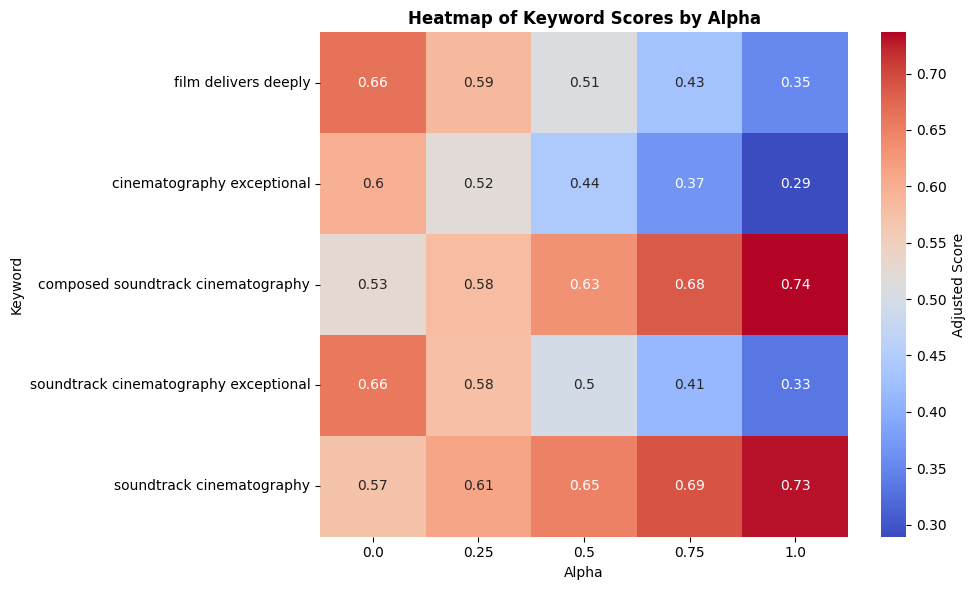

In [66]:
# Input review
review = (
    "The film delivers a deeply emotional and inspiring story, "
    "elevated by stunning performances and a beautifully composed soundtrack. "
    "The cinematography is exceptional, capturing every scene with elegance and precision. "
    "However, the pacing slows noticeably in the second act, and a few key plot twists feel "
    "unearned or underdeveloped. Despite these issues, the final act is powerful and rewarding, "
    "leaving a lasting emotional impact."
)

# Base KeyBERT
base_model = KeyBERT(model="sentence-transformers/all-MiniLM-L6-v2")
base_keywords = base_model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 3))

# Store sentiment-aware results for different alpha values
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
sa_results = {}

# Load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Run sentiment-aware KeyBERT reranker for each alpha
for alpha in tqdm(alphas, desc="Running Sentiment-Aware KeyBERT"):
    model = KeyBERTSentimentReranker(
        model=embedding_model,
        alpha=alpha,
        sentiment_model_name="nlptown/bert-base-multilingual-uncased-sentiment", # alternative: "cardiffnlp/twitter-roberta-base-sentiment"
        device="cpu"
    )
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 3))[0]
    sa_results[alpha] = keywords

# Display results
print("\nBase KeyBERT:")
pprint(base_keywords)

for alpha in alphas:
    print(f"\nSA-KeyBERT (alpha={alpha}):")
    pprint(sa_results[alpha])

# Prepare heatmap
labels = list(set(kw for kwlist in sa_results.values() for kw, _ in kwlist))
scores_by_alpha = {
    alpha: {kw: score for kw, score in sa_results[alpha]} for alpha in alphas
}

heatmap_data = pd.DataFrame({
    label: [scores_by_alpha[alpha].get(label, 0) for alpha in alphas]
    for label in labels
}, index=alphas)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Adjusted Score'})
plt.title("Heatmap of Keyword Scores by Alpha", fontweight='bold')
plt.xlabel("Alpha")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

## Test 2: Multi-review comparison

This second experiment evaluates the behavior of the `KeyBERTSentimentReranker` on a batch of multiple reviews with varying sentiment polarity. The goal is to assess consistency across documents and understand how different alpha values influence keyword selection.

**Objectives:**
- Apply sentiment-aware re-ranking to a small set of reviews (5–10).
- Compare the extracted keywords across different values of `alpha`.
- Identify whether sentiment alignment consistently improves coherence.

Each review is processed using `KeyBERTSentimentReranker` with increasing `alpha` values, and the resulting keywords are manually or visually inspected to evaluate the impact of sentiment-aware scoring.

In [67]:
# WordCloud of Most Representative Keywords Across All Reviews and Alphas
from wordcloud import WordCloud # type: ignore
from collections import Counter


Aggregating keywords for WordCloud: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


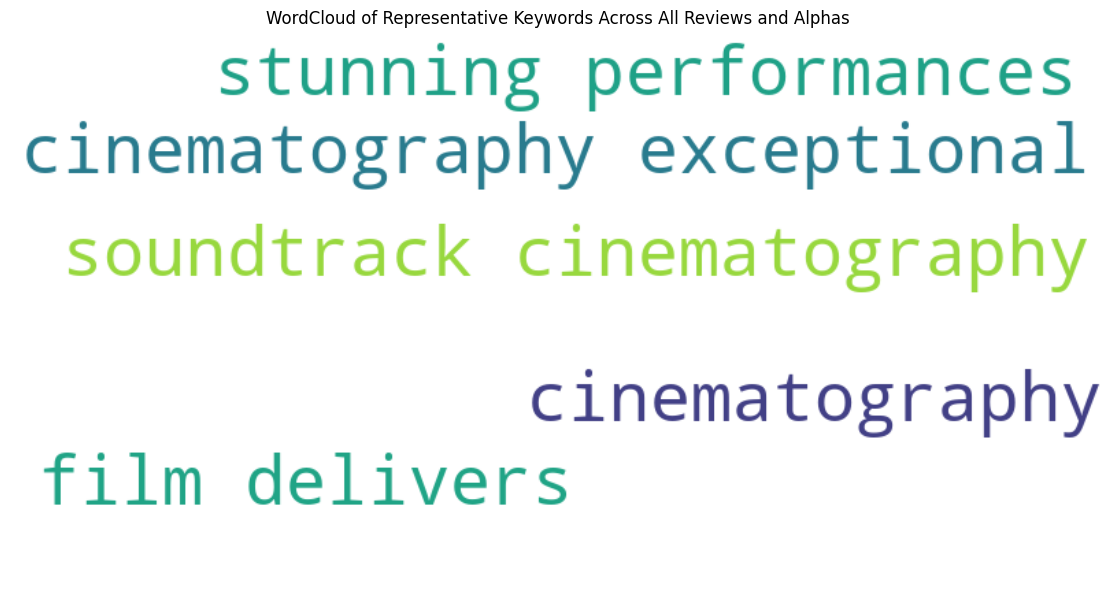

In [68]:
# Multi-review test (Test 2)
reviews = [
    "The movie was a masterpiece, emotionally engaging from beginning to end.",
    "I found the plot dull and the acting below average.",
    "Excellent pacing, witty dialogue, and great direction — truly enjoyable.",
    "It was a boring and predictable film with no originality whatsoever.",
    "Heartwarming story and brilliant performances made it unforgettable.",
    "Terribly written script with confusing transitions and weak characters.",
    "An uplifting experience with a beautiful soundtrack and strong emotional core.",
    "The film dragged on endlessly and failed to deliver any real tension.",
    "A visually stunning experience with a weak narrative.",
    "Strong start but disappointing ending; not worth the hype."
]

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

# Store and collect keywords across all alphas for WordCloud
total_counter = Counter()

# Load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

for alpha in tqdm(alphas, desc="Aggregating keywords for WordCloud"):
    model = KeyBERTSentimentReranker(alpha=alpha, model=embedding_model)
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
    total_counter.update([kw for kw, _ in keywords])

# WordCloud of Most Representative Keywords Across All Reviews and Alphas
word_freq_dict = dict(total_counter)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Representative Keywords Across All Reviews and Alphas")
plt.tight_layout()
plt.show()


## Test 3. Dataset test: `preprocessed_others_reviews_df.pkl`

This final experiment tests the `KeyBERTSentimentReranker` on a real-world dataset to evaluate its performance at scale. We apply the model to a set of 100 reviews and compare the results with the baseline KeyBERT approach.

**Objectives:**
- Run both baseline and sentiment-aware keyword extraction on a sample of real data.
- Analyze how sentiment influences keyword rankings in a larger, more varied context.
- Optionally compute metrics such as:
  - Distribution of document sentiment scores
  - Average positional shift of keywords when using sentiment-aware re-ranking

This test helps assess whether incorporating sentiment improves interpretability and ranking consistency in real applications.

In [69]:
import pickle

Extracting keywords (alpha=0.5): 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


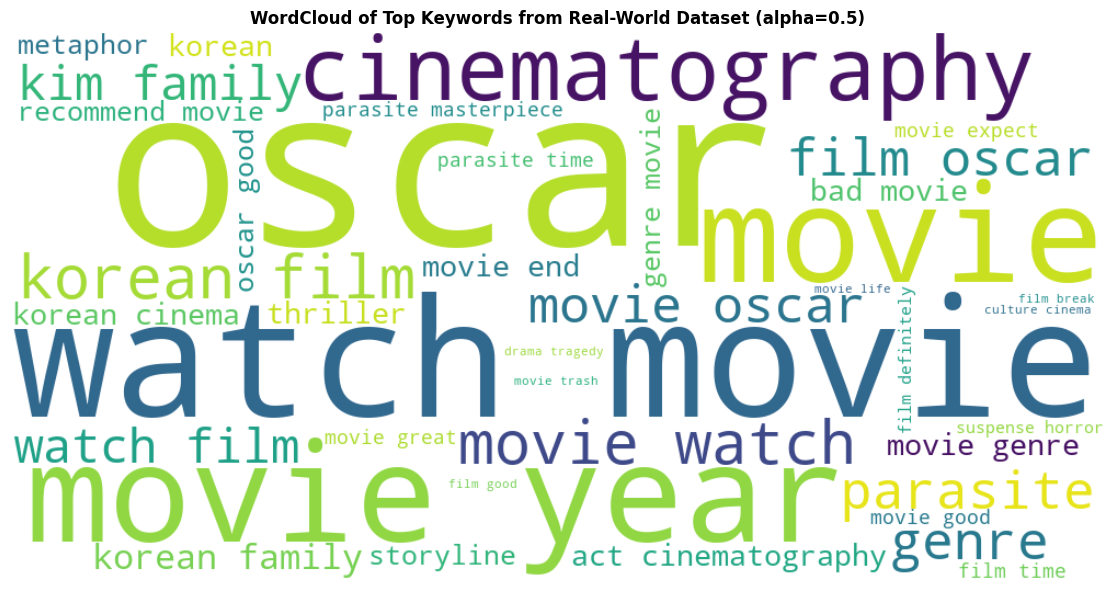

In [70]:
# Load preprocessed dataset
with open("../../Dataset/preprocessed_others_reviews_df.pkl", "rb") as f:
    df = pickle.load(f)

# Filter to reviews from the same film (using Movie_ID)
df = df[df["Movie_ID"] == df["Movie_ID"].iloc[0]].head(100)
reviews = df["Processed_Review_Text"].tolist()

# Load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Apply Sentiment-Aware KeyBERT with fixed alpha
alpha = 0.5
model = KeyBERTSentimentReranker(alpha=alpha, model=embedding_model)

# Extract keywords for each review
all_keywords = []
for review in tqdm(reviews, desc=f"Extracting keywords (alpha={alpha})"):
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
    all_keywords.extend([kw for kw, _ in keywords])

# Count most common keywords
counter = Counter(all_keywords)
top_keywords = dict(counter.most_common(40))  # limit to top N to avoid clutter

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Top Keywords from Real-World Dataset (alpha=0.5)", fontweight='bold')
plt.tight_layout()
plt.show()

## Test 4. Domain-specific test: `custom_preprocessed_others_reviews_df.pkl`

This final test explores the generalizability of `KeyBERTSentimentReranker` when applied to a custom or filtered subset of review data. The setup mirrors the previous real-world test but focuses on a more homogeneous or biased sample.

**Objectives:**
- Apply the reranker to a filtered set of 100 reviews.
- Evaluate whether sentiment-aware scoring remains effective in datasets with limited polarity variation.
- Observe whether aligned keywords still rise in rank, or if sentiment information has reduced influence.

This experiment helps assess the robustness of the approach under domain-specific or imbalanced conditions.

Extracting keywords (alpha=0.5): 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


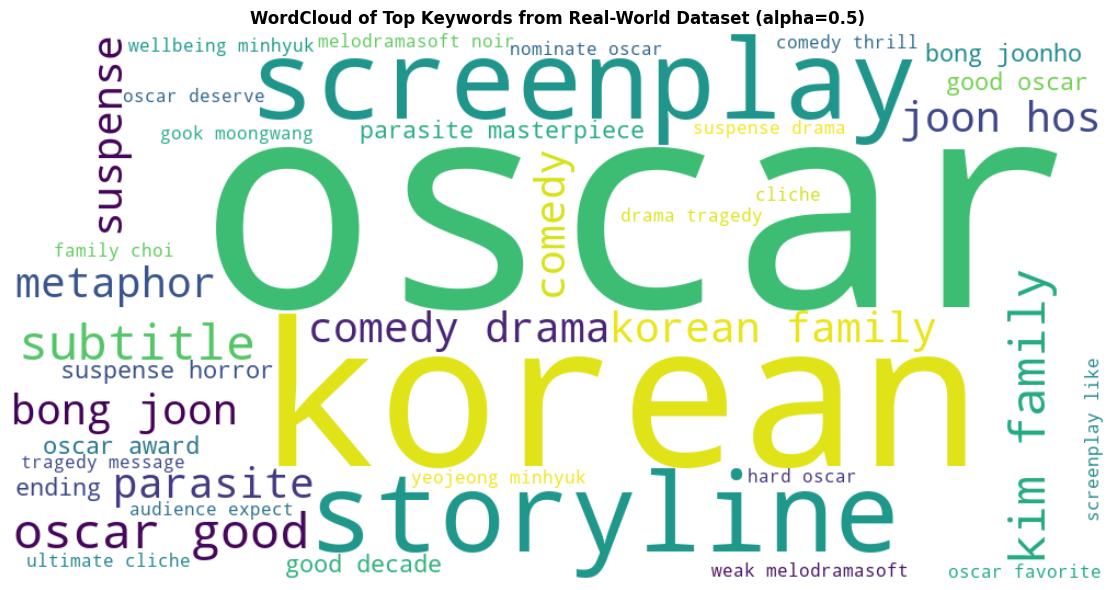

In [71]:
# Load preprocessed dataset
with open("../../Dataset/custom_preprocessed_others_reviews_df.pkl", "rb") as f:
    df = pickle.load(f)

# Filter to reviews from the same film (using Movie_ID)
df = df[df["Movie_ID"] == df["Movie_ID"].iloc[0]].head(100)
reviews = df["Processed_Review_Text"].tolist()

# Load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Apply Sentiment-Aware KeyBERT with fixed alpha
alpha = 0.5
model = KeyBERTSentimentReranker(alpha=alpha, model=embedding_model)

# Extract keywords for each review
all_keywords = []
for review in tqdm(reviews, desc=f"Extracting keywords (alpha={alpha})"):
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
    all_keywords.extend([kw for kw, _ in keywords])

# Count most common keywords
counter = Counter(all_keywords)
top_keywords = dict(counter.most_common(40))  # limit to top N to avoid clutter

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Top Keywords from Real-World Dataset (alpha=0.5)", fontweight='bold')
plt.tight_layout()
plt.show()
